<font color=#16A085>
    
# No acceptor excitation FRET Validation Report
Assess validation criteria to verify if the results of your FRET analysis comply with the theoretical relationships between parameters in the data.

</font>

---

## Introduction

<font color=#16A085>
    
#### How to use this notebook?
</font>

To use this notebook correctly, please follow the steps below.

1. Complete your FRET analysis in Mars. For more information please visit the documentation website (This notebook expects the output from one of the FRET example workflows https://duderstadt-lab.github.io/mars-docs/examples) 
2. Supply the full path to the archive created from the workflow (e.g. archive_name.yama).
3. Run all cells in this notebook (Cell/Run All, in the Jupyter notebook menu bar).
4. Inspect outcomes for Accepted molecules when compared to expected values and threshold ranges.
5. If desired, perform further filtering using the FRET_workflow_7_validation_filter groovy script.

<font color=#16A085>
    
#### Which criteria will be validated?
</font>

In this notebook, the following 6 criteria are assessed.
1. The sum of donor excited signals should be constant after corrections.
2. ~The sum of all signals should be constant after corrections.~ <font color=red>No Aex</font>
3. State transitions should exhibit donor and acceptor anti-correlation, until one dye bleaches.
4. ~Transitions between stoichiometry states should exhibit donor and acceptor anti-correlation, until one dye bleaches.~ <font color=red>No Aex, no stiochiometry</font>
5. The mean E of the DO population should be close to 0 after corrections.
6. ~The mean S of the AO population should be close to 0 after corrections.~ <font color=red>No Aex, no AO</font>

_Disclaimer: This notebook provides a few assessments we have found useful to confirm that selected molecules exhibit known features and relationships based on theory. These assessments can help to identify outliers exhibiting unexpected photophysical phenomena that invalidate their FRET analysis. Systematic issues may also appear more clearly using these assessments or collection issues in individual images. However, these assessments are limited and by no means represent an exhaustive validation of all FRET properties. Rather they offer a rough assessment and starting point for further exploration. This validation notebook does not substitute for manual curation which allows for rigorious inspection and likely results in the most optimal set of molecules for calculation of E and S distributions._ 

In [1]:
# File paths and names
file_path_fiji = '/Applications/Fiji-mars.app'  #Path to your Fiji application with Mars installed
saved_archive_name = '/Users/karlduderstadt4/git/mars-tutorials/Example_workflows/FRET/no_acceptor_excitation/holliday_junction_merged_corrections_without_aex.yama' #Path to your saved archive

In [2]:
# Import packages
import imagej

# Set the path to the local Fiji application if it does not exist yet
try:
    ij
except NameError:
    ij = imagej.init(file_path_fiji) 

# Import the other packages
import jpype
import jpype.imports
import scyjava as sc
import seaborn as sns, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
from scyjava import jimport
File = jimport("java.io.File")
from de.mpg.biochem.mars.molecule import SingleMoleculeArchive
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

# Set up the connection to the archive
yamaFile = File(saved_archive_name) 
archive = SingleMoleculeArchive(yamaFile)

#### Defining general functions

In [3]:
def create_molecule_parameter_df():
    '''Create a df with parameter information for all molecules in the archive, one molecule per row'''
    #Create a list containing all molecules in the archive
    molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
    
    #Create a list of all unique parameter names used by molecules
    parameterNames = list(sc.to_python(archive.properties().getParameterSet()))
    
    rowsList = []
    for molecule in molecules:
        rowDict = {}
        rowDict['UID'] = sc.to_python(molecule.getUID())
        rowDict['metaUID'] = sc.to_python(molecule.getMetadataUID())
        for param in parameterNames:
            if molecule.hasParameter(param):
                rowDict[param] = molecule.getParameter(param)
        if molecule.hasTag('FRET'):
            rowDict['Kind'] = 'FRET'
            if (molecule.getPosition('Donor_Bleach').getPosition() < molecule.getPosition('Acceptor_Bleach').getPosition()):
                rowDict['FirstBleach'] = 'Donor'
            else:
                rowDict['FirstBleach'] = 'Acceptor'
        if molecule.hasTag('AO'):
            rowDict['Kind'] = 'AO'
        if molecule.hasTag('DO'):
            rowDict['Kind'] = 'DO'
        if molecule.hasTag('Accepted'):
            rowDict['Accepted'] = 'Yes'
        else:
            rowDict['Accepted'] = 'No'
        rowsList.append(rowDict)
    
    return pd.DataFrame(rowsList)

In [4]:
def parameter_histplot(parameter, threshold):
    '''Convenience function for a global molecule parameter histplot'''
    fig,axes=plt.subplots(figsize=(5,2))

    sns.histplot(data=molecule_df[molecule_df['Kind'] == 'FRET'], 
                 x=parameter, hue='Accepted', alpha=1, 
                 hue_order=['Yes','No'], ax=axes, palette={'No': 'tab:blue', 'Yes': 'tab:orange'},
                 edgecolor='k', linewidth=0.5, binrange=(0, 1))

    axes.set_xlim([0, 1])
    axes.axvline(threshold, color='r', linestyle='--')
    axes.annotate("rejection region",(0.5,0.5), xycoords='axes fraction', color='r')
    plt.title("Global")
    plt.show()

In [5]:
def parameter_histplot_by_metaUID(parameter, threshold):
    '''Convenience function for molecule parameter histplots for each metaUID'''
    g = sns.FacetGrid(data=molecule_df[molecule_df['Kind'] == 'FRET'], 
                  row="metaUID", hue='Accepted', height=2, aspect=2)
    g.map(sns.histplot, parameter, alpha=1, 
          hue_order=['Yes','No'], palette={'No': 'tab:blue', 'Yes': 'tab:orange'},
          edgecolor='k', linewidth=0.5, binrange=(0, 1))
    for ax in g.axes.ravel():
        ax.legend()
        ax.axvline(threshold, color='r', linestyle='--')
        ax.annotate("rejection region",(0.5,0.5), xycoords='axes fraction', color='r')
        ax.set_xlim([0, 1])

    plt.show()

In [6]:
def parameter_barplot_by_metaUID(parameter, title, ylabel):
    '''Convenience function for comparison of mean parameter values for all metaUIDs'''
    fig,axes=plt.subplots(figsize=(2,2))
    sns.barplot(data=molecule_df[(molecule_df['Kind'] == 'FRET') & (molecule_df['Accepted'] == 'Yes')], 
                y=parameter, x='metaUID',color='gray')
    plt.xticks(rotation=60)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

---
## Build molecule parameter DataFrame

In [7]:
# For large datasets this can take a few minutes...
molecule_df = create_molecule_parameter_df()

### 1. The sum of donor excited signals should be constant

For all FRET molecules, Idemdex + Iaemdex should be constant until the moment one of the dyes bleaches. SUM_Dex (Idemdex + Iaemdex) is calculated for all time points for all FRET molecules by either the FRET_workflow_4_alex_corrections or the FRET_workflow_6_corrections_without_aex groovy script and added as the molecule parameter SUM_Dex_FRET_Coefficient_of_Variation. SUM_Dex should be constant, even during dynamic changes due to donor and acceptor anti-correlation. The [Coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) was calculated and added in several parameters to provide a measure of the stability of SUM_Dex.

Below histograms comparing all FRET molecules to Accepted FRET molecules are displayed with suggested threshold values. Molecules with high [Coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) values have sums of donor excited signals that are not constant. These should be considered for rejection.

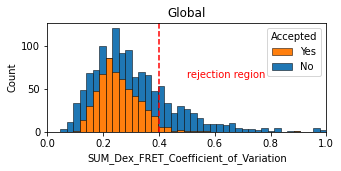

In [8]:
parameter_histplot('SUM_Dex_FRET_Coefficient_of_Variation', 0.4)

Coefficient of variation histograms for each metaUID are displayed below. Each metaUID represents a different video. Potential outlier videos can be identified using these plots.

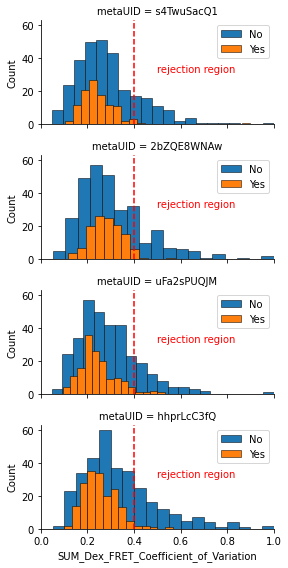

In [9]:
parameter_histplot_by_metaUID('SUM_Dex_FRET_Coefficient_of_Variation', 0.4)

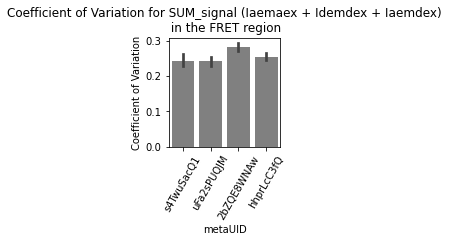

In [10]:
parameter_barplot_by_metaUID('SUM_Dex_FRET_Coefficient_of_Variation',
                            "Coefficient of Variation for SUM_signal (Iaemaex + Idemdex + Iaemdex)\n in the FRET region",
                            "Coefficient of Variation")

### 2. ~The sum of all signals should be constant among molecules~ <font color=red>No Aex</font>

~For all FRET molecules, Idemdex + Iaemdex + Iaemaex should be constant until the moment one of the dyes bleaches. SUM_signal (Idemdex + Iaemdex + Iaemaex) is calculated for all time points for all FRET molecules by either the FRET_workflow_4_alex_corrections groovy script and added as the molecule parameter SUM_signal_FRET_Coefficient_of_Variation. SUM_signal should be constant, even during dynamic changes due to donor and acceptor anti-correlation. The [Coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) was calculated and added in several parameters to provide a measure of the stability of SUM_signal.~

~Below histograms comparing all FRET molecules to Accepted FRET molecules are displayed with suggested threshold values. Molecules with high Coefficient of variation values have sums of all signals that are not constant. These should be considered for rejection.~

~Coefficient of variation histograms for each metaUID are displayed below. Each metaUID represents a different video. Potential outlier videos can be identified using these plots.~

### 3. State transitions should exihibit donor and acceptor anticorrelation in the FRET region

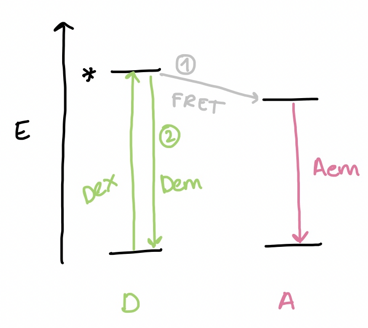

For FRET molecules, there are two possibilities after donor excitation: FRET followed by acceptor emission (1) or emission of the donor without an energy transfer process (2). The intensity in these two states should be anti-correlated. 

To assess donor and acceptor anti-correlation, the [Pearsons correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) was calculated in either the FRET_workflow_4_alex_corrections or the FRET_workflow_6_corrections_without_aex groovy script and added as the molecule parameter FRET_Pearsons_Correlation. Valid FRET molecules should have a negative Pearsons correlation representing anti-correlation of donor and acceptor emission. 

Below histograms comparing all FRET molecules to Accepted FRET molecules are displayed with suggested threshold values. Molecules with high or positive Pearsons correlation values do not exhibit donor and acceptor anti-correlation and should be considered for rejection.

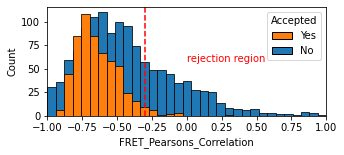

In [11]:
fig,axes=plt.subplots(figsize=(5,2))

sns.histplot(data=molecule_df[molecule_df['Kind'] == 'FRET'], 
             x='FRET_Pearsons_Correlation', hue='Accepted', alpha=1, 
             hue_order=['Yes','No'], ax=axes, palette={'No': 'tab:blue', 'Yes': 'tab:orange'},
             binrange=(-1, 1))

axes.set_xlim([-1, 1])
axes.axvline(-0.3, color='r', linestyle='--')
axes.annotate("rejection region",(0.5,0.5), xycoords='axes fraction', color='r')
plt.show()

### 4. ~Transitions between stoichiometry states should exhibit donor and acceptor anti-correlation, until both dyes are bleached.~ <font color=red>No Aex, no stiochiometry</font>

~Whenever dye fluorescence changes (through either dynamics, blinking or bleaching), the value of S should change accordingly. This means different values of S should be obtained for different parts of the trace that correlate with the number of dyes present. The most significant change in S occurs when one dye bleaches and the other dye remains fluorescent. After all corrections have been applied these are expected to change the stoichiometry from 0.5 (1 donor, 1 acceptor) to either 0 (1 acceptor) or 1 (1 donor).~

~Below are histograms of the S values of all FRET molecules and Accepted FRET molecules for these different bleaching senarios. Expected values are indicated on each of the histograms.~

---
### 5. The mean E of the DO molecules should be close to 0 after corrections

Since the donor only (DO) molecules, by definition, only contain a donor fluorophore and no acceptor fluorophore, theoretically the calculated FRET efficiency (E) should be 0. This follows directly from the formula for E:


$
E = \frac{Iaemdex}{Iaemdex + Idemdex} $

where Iaemdex approaches 0 since no acceptor fluorophore is present. Small deviations from E~0 are to be expected due to noise.

Below is the histogram comparing all DO molecules to Accepted DO molecules with the expected 0 value indicated.

<font color=#16A085>
    
#### Graphical exploration
</font>

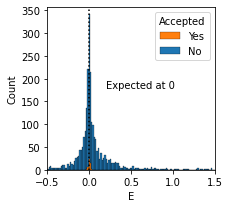

In [12]:
fig,axes=plt.subplots(figsize=(3,3))

sns.histplot(data=molecule_df[molecule_df['Kind'] == 'DO'], 
             x='E', hue='Accepted', alpha=1,  
             hue_order=['Yes','No'], ax=axes, palette={'No': 'tab:blue', 'Yes': 'tab:orange'},
             edgecolor='k', linewidth=0.25, binrange=(-0.5, 1.5))
axes.set_xlim([-0.5, 1.5])

axes.axvline(0,color='black',linestyle=':') 
axes.annotate("Expected at 0",(0.35,0.5), xycoords='axes fraction', color='k')
plt.show()

<font color=#16A085>
    
#### Numerical exploration
</font>

In [13]:
# Numerical exploration: median value of E
molecule_df[molecule_df['Kind'] == 'DO']['E'].median()

0.003989141702630676

---
### 6.  ~The mean S of the AO molecules should be close to 0 after corrections~ <font color=red>No Aex, no AO</font>

~Since the acceptor only (AO) molecules, by definition, only contain an acceptor fluorophore and no donor fluorophore, theoretically the calculated FRET Stoichiometry (S) should be 0. This follows directly from the formula for S:~


$
S = \frac{Iaemdex + Idemdex}{Iaemdex + Idemdex + Iaemaex} $

~where Idemdex and Iaemdex (FRET) both approach 0 since no donor fluorophore is present. Small deviations from S~0 are to be expected due to noise.~

~Below is the histogram comparing all AO molecules to Accepted AO molecules with the expected 0 value indicated.~